In [ ]:
from tqdm import tqdm
import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM
import os
import numpy as np
import pandas as pd

In [ ]:
print(tf.__version__)
print(tf.test.is_gpu_available())

In [3]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.set_random_seed(7)

In [4]:
train = pd.read_csv('./data/train.csv', encoding = 'utf-8', header = 1, index_col = 'id')
test = pd.read_csv('./data/test.csv', encoding = 'utf-8', index_col = 'id')
print(train.head())
print(test.head())
print(len(train))

    X00    X01  X02  X03  X04     X05    X06   X07     X08     X09  ...  Y09  \
id                                                                  ...        
0   9.7  988.8  1.2  0.6  0.0  1009.3  989.6  12.2  1009.9  1009.8  ...  7.0   
1   9.3  988.9  1.7  1.9  0.0  1009.3  989.6  12.1  1010.0  1009.9  ...  6.5   
2   9.4  989.0  1.1  2.3  0.0  1009.2  989.7  12.1  1010.1  1010.1  ...  6.5   
3   9.4  988.9  1.5  0.7  0.0  1009.2  989.6  12.0  1010.0  1010.0  ...  6.0   
4   9.2  988.9  0.8  1.7  0.0  1009.2  989.7  12.0  1010.1  1010.0  ...  6.0   

    Y10  Y11  Y12   Y13  Y14  Y15  Y16  Y17  Y18  
id                                                
0   7.5  7.0  9.0  10.0  9.5  9.0  8.0  9.0  NaN  
1   7.5  7.0  8.5  10.0  9.5  9.0  7.5  9.0  NaN  
2   7.5  6.5  8.0   9.5  9.5  8.5  7.5  8.5  NaN  
3   7.0  6.0  8.0   9.5  9.0  8.5  7.5  8.5  NaN  
4   7.0  6.0  7.5   9.5  9.0  8.5  7.5  8.5  NaN  

[5 rows x 59 columns]
       X00    X01  X02  X03  X04     X05    X06   X07     X

In [5]:
train.describe()

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
count,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,...,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,432.000000
mean,20.227904,988.621107,1.509764,1.453157,1.270223,1008.333902,989.005093,21.658081,1008.790341,1008.394171,...,22.222801,23.737269,24.649653,23.641898,20.926157,21.319444,21.564468,22.969097,23.381829,26.687500
std,4.707570,3.359916,1.071858,0.936151,4.429852,3.395037,3.403714,4.377216,3.520317,3.546180,...,9.112299,10.599000,12.214870,8.400081,6.106031,7.066149,6.810084,8.054272,9.275172,6.286621
min,8.300000,977.300000,0.000000,0.000000,0.000000,997.200000,978.100000,11.600000,997.300000,996.300000,...,3.500000,4.000000,3.000000,6.000000,7.500000,7.500000,7.000000,6.000000,7.000000,18.500000
25%,16.900000,986.800000,0.700000,0.800000,0.000000,1006.500000,987.100000,18.400000,1006.700000,1006.300000,...,15.500000,15.500000,15.000000,17.000000,16.500000,16.500000,16.500000,16.500000,16.000000,21.000000
50%,19.900000,988.600000,1.300000,1.300000,0.000000,1008.500000,989.100000,21.200000,1008.800000,1008.400000,...,20.000000,20.500000,21.000000,22.000000,19.500000,19.500000,20.000000,21.500000,20.000000,25.000000
75%,24.100000,991.000000,2.100000,2.000000,0.000000,1010.800000,991.600000,24.825000,1011.400000,1010.900000,...,30.500000,32.500000,34.500000,30.500000,25.000000,25.000000,27.000000,30.000000,32.000000,31.500000
max,30.900000,997.200000,10.200000,5.800000,25.600000,1016.800000,997.400000,32.700000,1017.500000,1018.000000,...,42.000000,49.000000,53.000000,43.500000,38.000000,42.500000,40.500000,41.500000,43.500000,41.500000


In [6]:
#33일은 4752행, 30일은 4320행까지. 30~33일치 사이는 4320 id부터 4751 id까지.
#Y18의 3일치와 X31, X32는 상관성이 높음
#X31, X32
X_train = train.loc[4320:4751, 'X31':'X32']
X_train

,X31,X32
id,,
4320,18.0,18.7
4321,17.7,19.0
4322,17.4,19.2
4323,17.5,19.3
4324,17.4,19.5
...,...,...
4747,17.7,19.1
4748,17.7,19.2
4749,17.8,19.2


In [7]:
#X31과 X32의 평균값으로 재설정(추후 weight 조정해서 재계산 가능)
X_train['mean'] = (X_train['X31']+X_train['X32'])/(2)
    #X_train[i]['mean'] = np.mean(X_train[i]['X31'], X_train[i]['X32'])
X_train = X_train['mean'].reset_index(drop = True)

In [8]:
#index 새로 부여한 데이터 생성
y18 = train[~train['Y18'].isnull()]['Y18'].reset_index(drop= True)

In [9]:
print(len(X_train))
print(len(y18))

432
432


In [10]:
X_train

0      18.35
1      18.35
2      18.30
3      18.40
4      18.45
       ...  
427    18.40
428    18.45
429    18.50
430    18.50
431    18.60
Name: mean, Length: 432, dtype: float64

In [11]:
y18

0      20.5
1      20.5
2      20.5
3      20.5
4      20.5
       ... 
427    21.5
428    21.5
429    21.5
430    21.5
431    21.0
Name: Y18, Length: 432, dtype: float64

In [22]:
print(type(X_train))
print(type(y18))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [23]:
X = np.array(X_train)
print(type(X))
print(X)

<class 'numpy.ndarray'>
[18.35 18.35 18.3  18.4  18.45 18.5  18.55 18.5  18.6  18.5  18.5  18.35
 18.3  18.5  18.35 18.2  18.2  18.2  18.1  17.85 17.9  17.85 17.8  17.9
 17.9  17.9  17.85 17.75 17.75 17.8  17.85 18.   18.05 18.15 18.2  18.3
 18.45 18.7  18.85 19.   19.1  19.45 19.75 19.8  20.15 20.2  20.7  20.95
 20.75 21.15 21.45 21.45 22.   21.95 21.7  21.75 22.05 22.55 22.5  22.25
 22.75 23.3  23.25 23.35 23.65 23.2  24.4  24.2  24.25 24.95 24.6  24.7
 25.25 25.6  25.55 25.8  25.75 26.7  26.1  26.2  26.45 26.7  27.4  27.35
 27.25 27.25 27.75 27.85 27.65 27.55 27.7  27.7  27.55 28.1  28.25 28.4
 28.55 28.3  28.25 28.25 28.2  28.05 28.1  27.8  27.45 27.6  27.3  27.15
 26.8  26.55 26.7  26.4  26.25 25.95 25.7  25.55 25.3  24.8  24.15 24.
 23.95 23.65 23.3  23.25 22.95 22.85 22.7  22.6  22.2  22.35 22.2  21.8
 21.65 21.5  21.35 21.35 21.25 21.45 21.35 21.2  20.8  20.9  20.55 20.45
 20.7  20.55 20.35 20.35 20.3  19.8  19.9  20.   20.   19.75 19.45 19.55
 19.75 19.85 19.8  19.85 19.8  19.

In [24]:
Y = np.array(y18)
print(type(Y))
print(Y)

<class 'numpy.ndarray'>
[20.5 20.5 20.5 20.5 20.5 20.5 20.5 20.5 20.5 20.5 20.5 20.5 20.5 20.5
 20.5 20.5 20.  20.  20.  19.5 19.  19.  19.  19.  19.  19.  19.  19.
 19.  19.  19.  19.  18.5 18.5 19.  19.  19.5 19.5 20.  20.  20.5 20.5
 21.  21.5 22.  23.5 24.5 25.5 27.  28.5 28.  27.  26.  25.5 25.5 25.
 25.5 25.5 25.5 26.  26.  27.  27.5 27.5 28.5 30.  29.5 29.5 29.  30.5
 33.5 35.5 35.  36.  37.  37.5 38.  37.  37.5 37.  36.5 36.  35.5 36.
 36.5 37.  35.5 33.5 32.5 32.  31.5 31.5 31.  31.  31.  31.5 31.5 31.5
 31.5 31.5 31.5 31.  30.5 30.5 30.  30.  29.5 29.5 29.  28.5 28.5 28.5
 28.  28.  27.5 27.5 27.  26.5 26.5 26.  25.5 25.5 25.  25.  24.5 24.5
 24.5 24.  24.  23.5 23.5 23.  23.  23.  22.5 22.5 22.5 22.5 22.5 22.
 22.  22.  22.  22.  22.  22.  22.  21.5 21.5 21.5 21.5 21.  21.  21.
 21.  21.  21.  21.  21.  21.  21.  21.  21.  21.  21.  21.  21.  21.
 20.5 20.5 20.5 20.  20.  19.5 19.5 19.5 20.  20.  20.  20.5 20.5 20.5
 21.  21.  21.5 21.5 22.  22.  22.5 23.  23.5 24.  24.  24.

In [12]:
# loss가 4미만으로 떨어지면 학습 종료 시키는 기능
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if(logs.get('loss') < 4):
            print('\n Loss is under 4, cancelling training')
            self.model.stop_training = True

In [13]:
callbacks = myCallback()

In [14]:
from sklearn.model_selection import train_test_split

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [29]:
print(x_train.shape)
print(y_train.shape)

(345,)
(345,)


In [115]:
x_train = x_train.reshape((345, 1, 1))
print(x_train.shape)

(345, 1, 1)


In [116]:
y_train = y_train.reshape((345,1, 1))

In [117]:
#data_dim = 1
#timesteps = 1
data_dim = x_train[-1]
timesteps = x_train[-2]

In [118]:
len(x_train)

345

In [123]:
x_test = x_test.reshape((87,1, 1))
y_test = y_test.reshape((87,1, 1))

In [119]:
model = Sequential()
model.add(LSTM(128,  return_sequences=True, input_shape=(timesteps, data_dim)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

In [120]:
model.compile(optimizer='adam',
              loss='mse')

In [121]:
# 모델 학습
model.fit(    
    x_train, y_train,
    epochs=600,
    batch_size=8,
    verbose=2,
    shuffle=False,
    )

Epoch 1/600
 - 3s - loss: 341.4088
Epoch 2/600
 - 0s - loss: 23.0599
Epoch 3/600
 - 0s - loss: 15.2833
Epoch 4/600
 - 0s - loss: 11.6911
Epoch 5/600
 - 0s - loss: 10.0177
Epoch 6/600
 - 0s - loss: 9.5067
Epoch 7/600
 - 0s - loss: 9.2761
Epoch 8/600
 - 0s - loss: 9.2234
Epoch 9/600
 - 0s - loss: 9.1989
Epoch 10/600
 - 0s - loss: 9.1839
Epoch 11/600
 - 0s - loss: 9.1700
Epoch 12/600
 - 0s - loss: 9.1538
Epoch 13/600
 - 0s - loss: 9.1456
Epoch 14/600
 - 0s - loss: 9.1347
Epoch 15/600
 - 0s - loss: 9.1286
Epoch 16/600
 - 0s - loss: 9.1129
Epoch 17/600
 - 0s - loss: 9.1046
Epoch 18/600
 - 0s - loss: 9.0998
Epoch 19/600
 - 0s - loss: 9.0829
Epoch 20/600
 - 0s - loss: 9.0809
Epoch 21/600
 - 0s - loss: 9.0719
Epoch 22/600
 - 0s - loss: 9.0658
Epoch 23/600
 - 0s - loss: 9.0526
Epoch 24/600
 - 0s - loss: 9.0408
Epoch 25/600
 - 0s - loss: 9.0294
Epoch 26/600
 - 0s - loss: 9.0218
Epoch 27/600
 - 0s - loss: 9.0025
Epoch 28/600
 - 0s - loss: 8.9925
Epoch 29/600
 - 0s - loss: 8.9788
Epoch 30/600
 - 0

Epoch 238/600
 - 0s - loss: 7.8387
Epoch 239/600
 - 0s - loss: 7.8408
Epoch 240/600
 - 0s - loss: 7.8314
Epoch 241/600
 - 0s - loss: 7.8374
Epoch 242/600
 - 0s - loss: 7.8382
Epoch 243/600
 - 0s - loss: 7.8498
Epoch 244/600
 - 0s - loss: 7.8451
Epoch 245/600
 - 0s - loss: 7.8383
Epoch 246/600
 - 0s - loss: 7.8470
Epoch 247/600
 - 0s - loss: 7.8407
Epoch 248/600
 - 0s - loss: 7.8481
Epoch 249/600
 - 0s - loss: 7.8433
Epoch 250/600
 - 0s - loss: 7.8328
Epoch 251/600
 - 0s - loss: 7.8348
Epoch 252/600
 - 0s - loss: 7.8343
Epoch 253/600
 - 0s - loss: 7.8300
Epoch 254/600
 - 0s - loss: 7.8389
Epoch 255/600
 - 0s - loss: 7.8257
Epoch 256/600
 - 0s - loss: 7.8357
Epoch 257/600
 - 0s - loss: 7.8315
Epoch 258/600
 - 0s - loss: 7.8325
Epoch 259/600
 - 0s - loss: 7.8228
Epoch 260/600
 - 0s - loss: 7.8241
Epoch 261/600
 - 0s - loss: 7.8265
Epoch 262/600
 - 0s - loss: 7.8262
Epoch 263/600
 - 0s - loss: 7.8277
Epoch 264/600
 - 0s - loss: 7.8197
Epoch 265/600
 - 0s - loss: 7.8313
Epoch 266/600
 - 0s 

In [124]:
score = model.evaluate(x_test, y_test, verbose = 1)

87/87 [==============================] - ETA:  - 1s 9ms/step


In [127]:
print(score)

4.749349336514528


In [128]:
X_pre = train.loc[0:4320, 'X31':'X32']
X_pre['mean'] = (X_pre['X31']+X_pre['X32'])/(2)
X_pre = X_pre['mean'].reset_index(drop = True)

In [131]:
X_pre30 = np.array(X_pre)

In [133]:
X_pre30 = X_pre30.reshape(4321, 1, 1)

In [134]:
y_pred = model.predict(X_pre30)

In [135]:
print(y_pred)

[[[12.838042]]

 [[12.70976 ]]

 [[12.322598]]

 ...

 [[20.319237]]

 [[20.018314]]

 [[20.068653]]]


In [138]:
len(y_pred)

4321

In [154]:
X_post = test.loc[4752:16271, 'X31':'X32']
X_post['mean'] = (X_post['X31']+X_post['X32'])/(2)
X_post = X_post['mean'].reset_index(drop = True)
X_post80 = np.array(X_post)

In [155]:
X_post80.shape

(11520,)

In [156]:
X_post80 = X_post80.reshape(11520, 1, 1)
y_pred80 = model.predict(X_post80)

In [139]:
# 제출 파일 만들기
submit4 = pd.DataFrame({'id':range(0, 4321),
              'Y18':y_pred.reshape(1,-1)[0]})

In [158]:
y80_submit = pd.DataFrame({'id':range(4752, 16272),
              'Y18':y_pred80.reshape(1,-1)[0]})

In [146]:
submit4.to_csv('0411상관관계테스트.csv', index = False)

In [159]:
y80_submit.to_csv('0411상관관계_80일치결과.csv', index = False)

In [141]:
submit4.head()

,id,Y18
0,0,12.838042
1,1,12.709760
2,2,12.322598
3,3,12.063215
4,4,11.932869


No handles with labels found to put in legend.


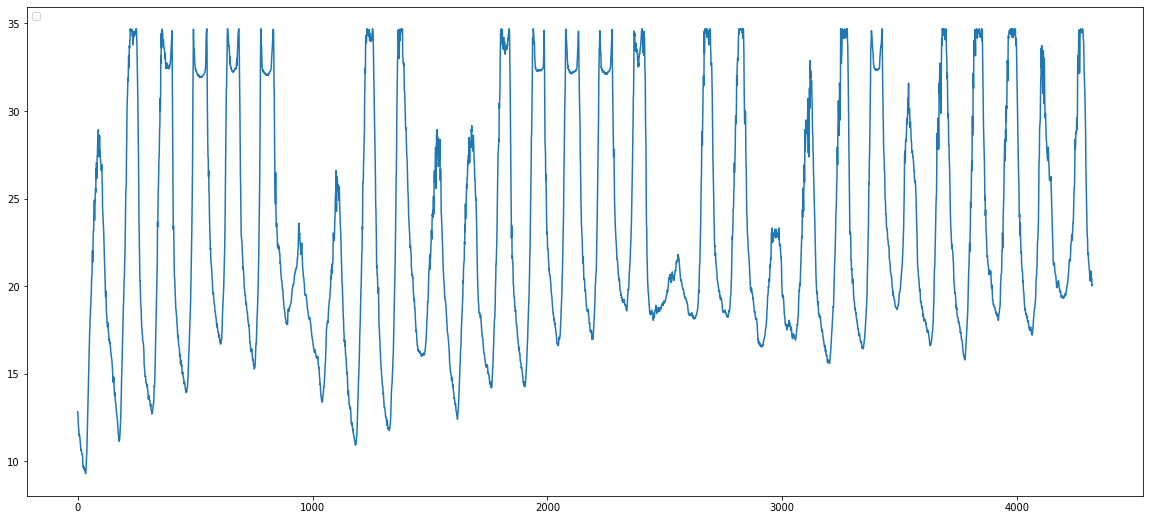

In [147]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 9))
plt.plot(submit4['Y18'])
plt.legend(loc='upper left')
plt.show()

In [161]:
baseline = pd.read_csv('baseline_result.csv')

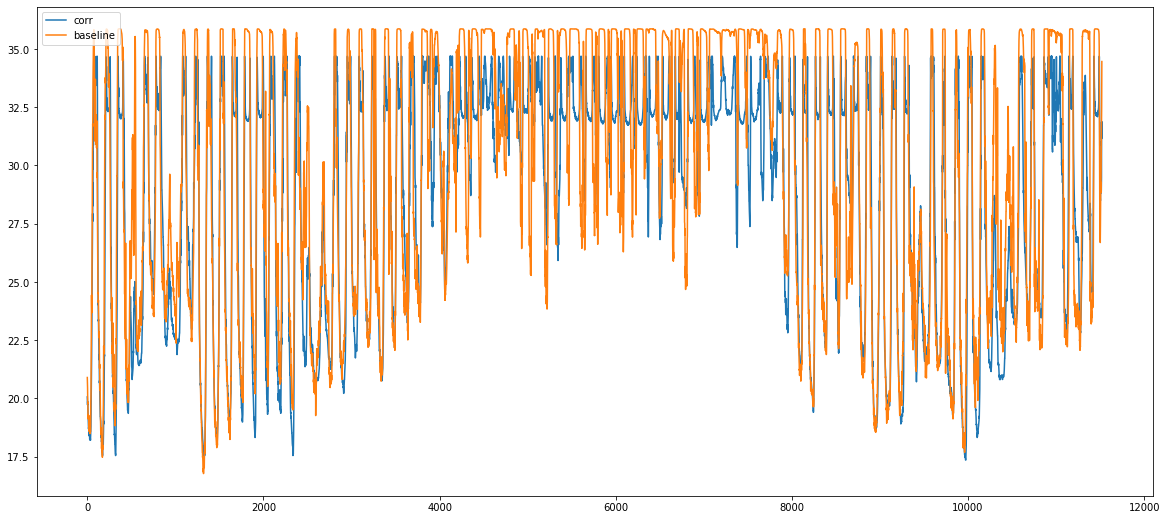

In [162]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 9))
plt.plot(y80_submit['Y18'])
plt.plot(baseline['Y18'])
plt.legend(['corr', 'baseline'], loc='upper left')
plt.show()